# Timelag Analysis: Nonequilibrium versus Equilibrium Ionization
For one of our heating cases (likely intermediate-frequency heating), compare the timelag distributions for intensities computed accounting for non-equilibrium ionization and assuming equilibrium ionization

May need to look at a few different heating scenarios. Thus far,
* low frequency
* ~~intermediate frequency~~
* ~~cooling~~

Essentially no differences seen in intermediate frequency case

In [1]:
import os
import sys

import numpy as np
import dask
import distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import SqrtStretch,ImageNormalize,AsinhStretch,LogStretch

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../scripts/')
from timelags import AIATimeLags

%matplotlib inline

In [2]:
client = distributed.Client(processes=False)

In [3]:
client

Client Scheduler: inproc://128.42.128.76/3706/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 64 Memory: 270.38 GB


In [57]:
client.close()

## Compute Timelags

Load in previous results for NEI

In [4]:
aia_nei = InstrumentSDOAIA([5000,25000]*u.s,)
aia_nei.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA_counts.h5'

In [5]:
timelags_nei = AIATimeLags(aia_nei, 'intensity_maps_low_frequency.h5', )

Load results for IEQ

In [6]:
aia_ieq = InstrumentSDOAIA([5000,25000]*u.s)
aia_ieq.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/ieq/SDO_AIA_counts.h5'

In [7]:
timelags_ieq = AIATimeLags(aia_ieq, 'intensity_maps_low_frequency_ieq.h5',
                           #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/ieq/'
                          )

Preview intensity maps

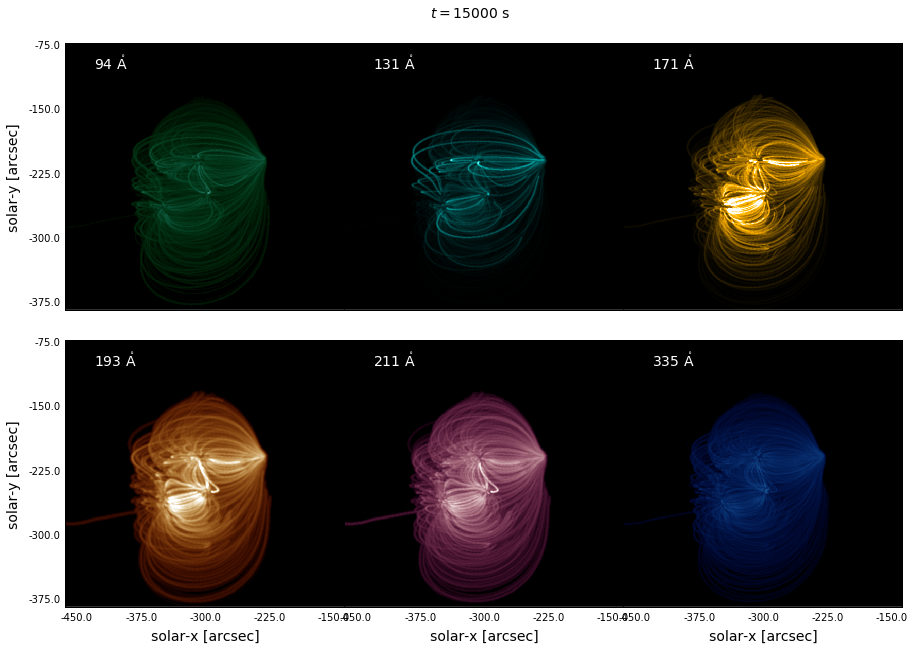

In [8]:
plot_aia_channels(aia_ieq,15000*u.s,
                  '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/ieq/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()))

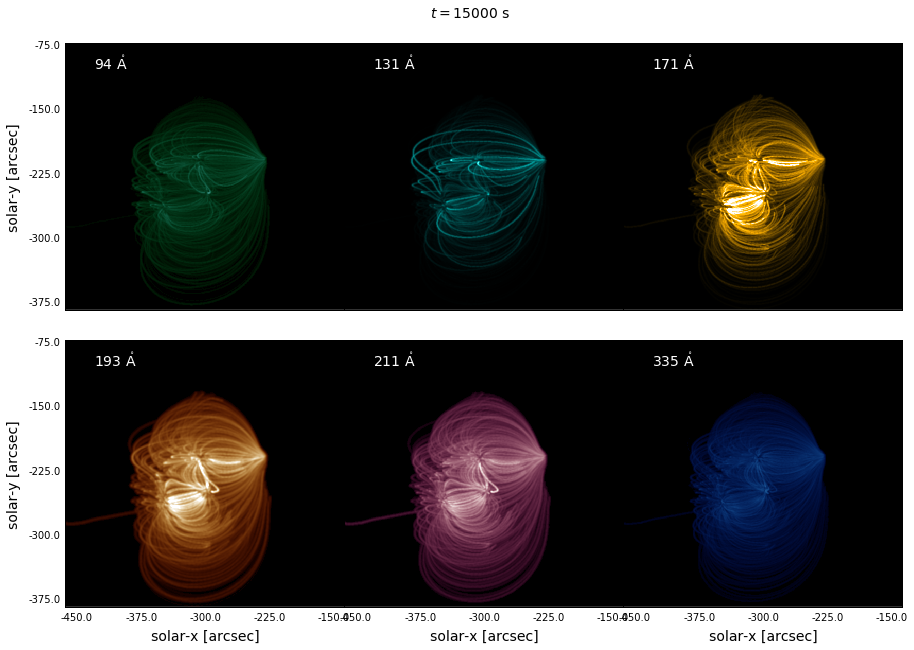

In [9]:
plot_aia_channels(aia_nei,15000*u.s,
                  '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/',
                  norm=ImageNormalize(vmin=0,vmax=5e2,stretch=SqrtStretch()))

### Some 1D Results

In [10]:
xc,yc = -340*u.arcsec, -200*u.arcsec
dx,dy = 5*u.arcsec, 5*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)

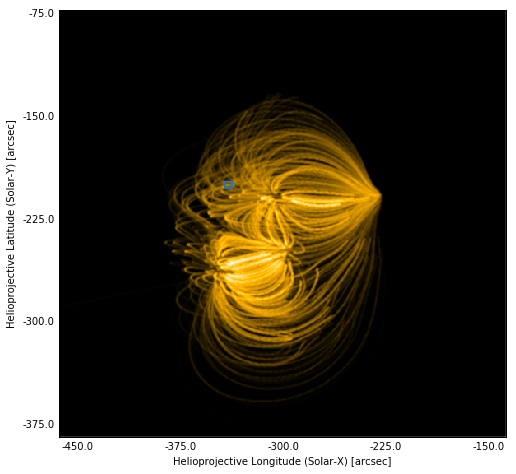

In [12]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/ieq/SDO_AIA/171/map_t001500.fits')
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=m)
m.plot(axes=ax,title=False)
ax.grid(alpha=0)
m.draw_rectangle(SkyCoord(*lower_left_corner,frame=m.coordinate_frame),dx,dy,axes=ax,color='C0',lw=2)

In [13]:
# Extract timeseries
timeseries = {}
coords  = (lower_left_corner,upper_right_corner)
for i,channel in enumerate(aia_nei.channels):
    timeseries[channel['name']] = {}
    # Eqm timeseries
    timeseries[channel['name']]['ieq'] = timelags_ieq.make_timeseries(channel['name'],*coords)
    # NEI timeseries
    timeseries[channel['name']]['nei'] = timelags_nei.make_timeseries(channel['name'],*coords)

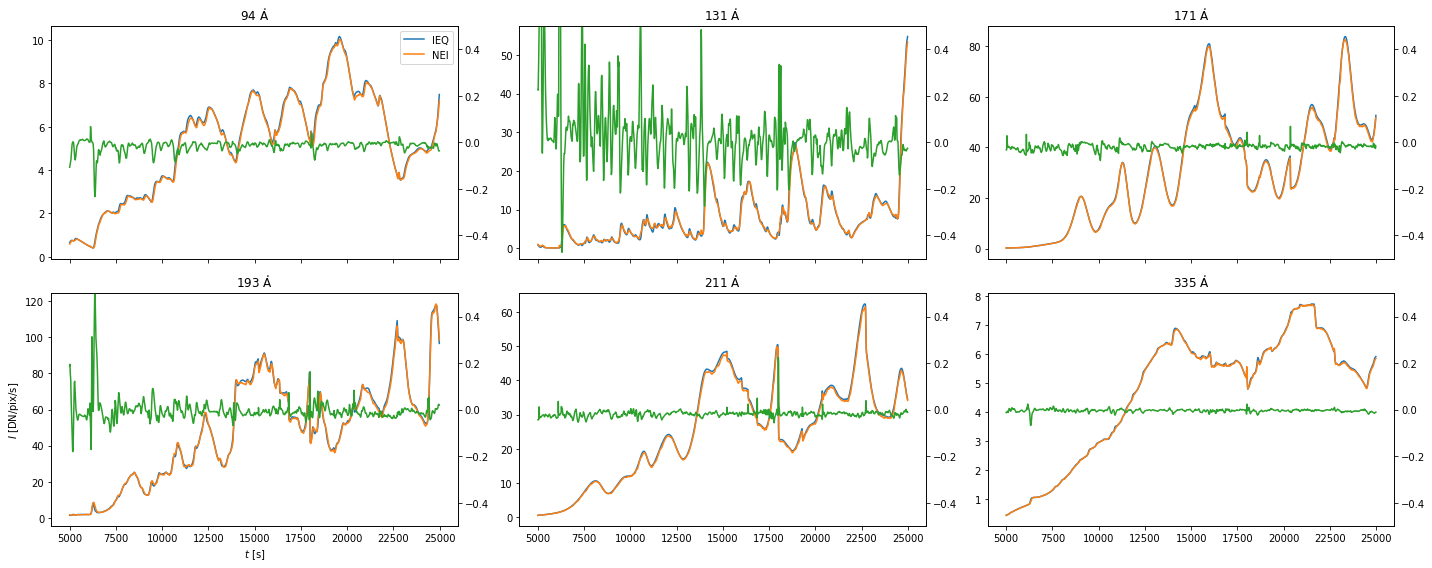

In [14]:
# plot timeseries
fig,axes = plt.subplots(2,3,figsize=(20,8),sharex=True,)
for i,(channel,ax) in enumerate(zip(aia_nei.channels,axes.flatten())):
    # Eqm timeseries
    ax.plot(aia_ieq.observing_time,
            timeseries[channel['name']]['ieq'],
            color=f'C0',label='IEQ')
    # NEI timeseries
    ax.plot(aia_nei.observing_time,
            timeseries[channel['name']]['nei'],
            color=f'C1',label='NEI')
    # Diff
    intensity_diff = timeseries[channel['name']]['nei'] - timeseries[channel['name']]['ieq']
    intensity_diff /= timeseries[channel['name']]['ieq']
    ax_diff = ax.twinx()
    ax_diff.plot(aia_ieq.observing_time, intensity_diff, color='C2', label='difference')
    ax_diff.set_ylim(-.5,.5)
    #ax_diff.set_yscale('symlog',linthreshy=1e-2)
    # Title and scale
    ax.set_title(f'{channel["name"]} $\mathring{{\mathrm{{A}}}}$')
    # ax.set_yscale('log')
axes[0,0].legend()
axes[1,0].set_xlabel(r'$t$ [s]')
axes[1,0].set_ylabel(r'$I$ [DN/pix/s]')
#axes[0,0].set_xlim([10000,12500])
#plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.tight_layout()

In [15]:
channel_pairs = [(94,335),(94,171),(335,211),(335,171),(193,171),(171,131)]

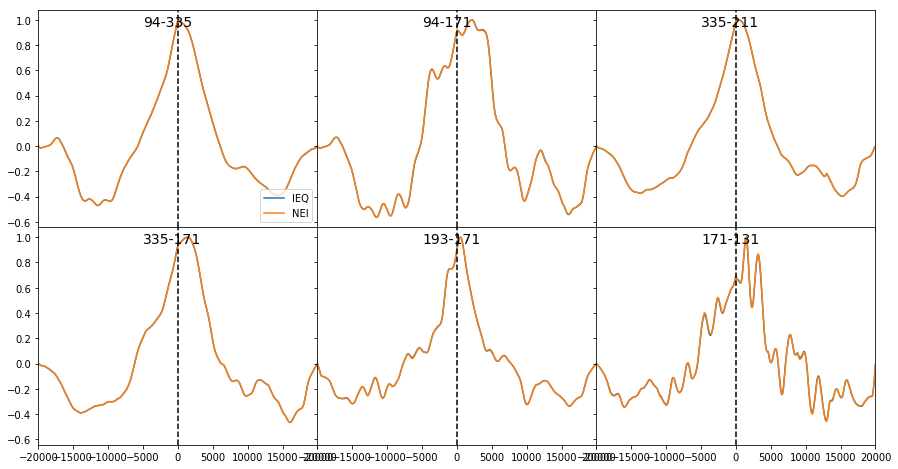

In [16]:
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    # ieq
    cc_ieq = timelags_ieq.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(timelags_ieq.timelags,cc_ieq/cc_ieq.max(),color='C0',ls='-',label='IEQ')
    # nei
    cc_nei = timelags_nei.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(timelags_nei.timelags,cc_nei/cc_nei.max(),color=f'C1',ls='-',label='NEI')
    ax.axvline(x=0,ls='--',color='k')
    ax.text(-5e3,0.95,'{}-{}'.format(*p),fontsize=14)
axes[0,0].set_xlim([-2e4,2e4])
axes[0,0].legend(loc=4,ncol=1)
plt.subplots_adjust(hspace=0,wspace=0)

### Timelag Maps

In [17]:
timelag_maps = {}
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)] = {}
    timelag_maps['{}-{}'.format(*p)]['ieq'] = timelags_ieq.make_timelag_map(f'{p[0]}',f'{p[1]}')
    timelag_maps['{}-{}'.format(*p)]['nei'] = timelags_nei.make_timelag_map(f'{p[0]}',f'{p[1]}')

In [18]:
correlation_maps = {}
for p in channel_pairs:
    correlation_maps['{}-{}'.format(*p)] = {}
    correlation_maps['{}-{}'.format(*p)]['ieq'] = timelags_ieq.make_correlation_map(f'{p[0]}',f'{p[1]}')
    correlation_maps['{}-{}'.format(*p)]['nei'] = timelags_nei.make_correlation_map(f'{p[0]}',f'{p[1]}')

## Compare Results

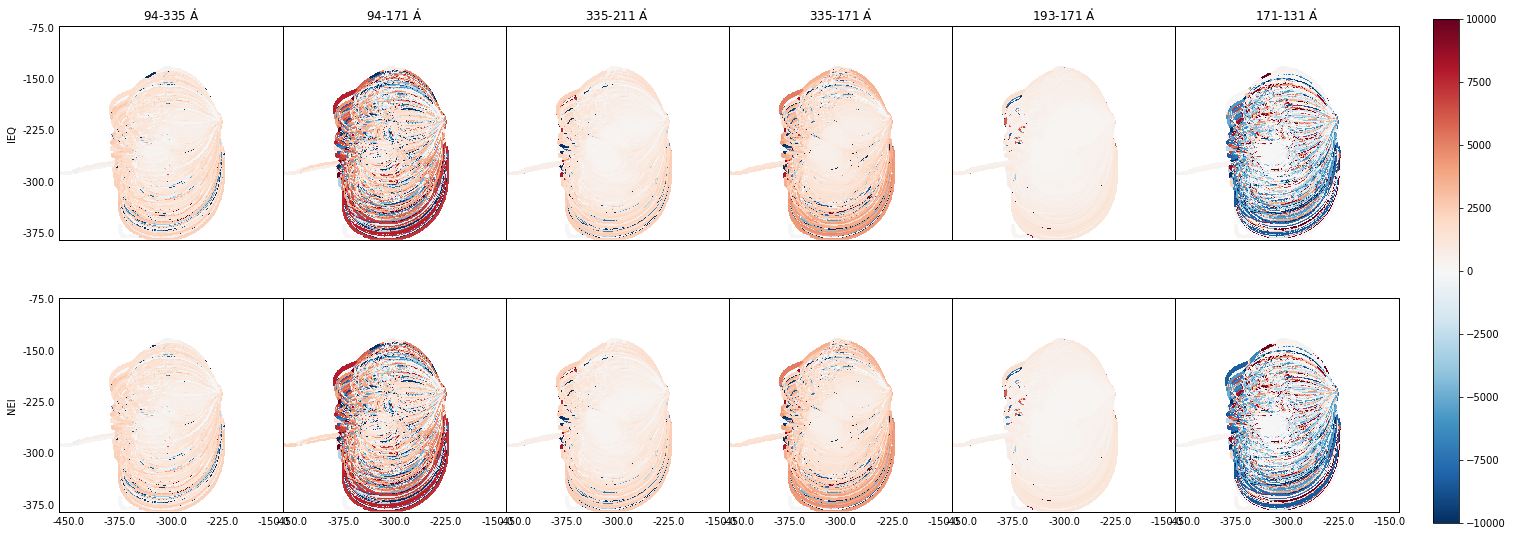

In [19]:
fig = plt.figure(figsize=(24,10))
plt.subplots_adjust(hspace=0,wspace=0)
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,(c_a,c_b) in enumerate(channel_pairs):    
    # IEQ
    tmp = timelag_maps[f'{c_a}-{c_b}']['ieq']
    tmp_cor = correlation_maps[f'{c_a}-{c_b}']['ieq']
    data = np.where(tmp_cor.data / tmp_cor.data.max() < 0.2, np.nan, tmp.data)
    tmp = Map(data, tmp.meta)
    tmp.plot_settings.update({'cmap':'RdBu_r','vmin':-1e4,'vmax':1e4})
    ax = fig.add_subplot(2,len(channel_pairs), i+1, projection=tmp)
    im = tmp.plot(annotate=False,title=False)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.grid(draw_grid=False)
    lat.grid(draw_grid=False)
    # Set labels and grids accordingly
    ax.set_title(f'{c_a}-{c_b} $\mathrm{{\mathring{{A}}}}$')
    lon.set_ticklabel_visible(False)
    lon.set_ticks_visible(False)
    if i==0:
        lat.set_axislabel('IEQ')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    
    # NEI
    tmp = timelag_maps[f'{c_a}-{c_b}']['nei']
    tmp_cor = correlation_maps[f'{c_a}-{c_b}']['nei']
    data = np.where(tmp_cor.data / tmp_cor.data.max() < 0.2, np.nan, tmp.data)
    tmp = Map(data, tmp.meta)
    tmp.plot_settings.update({'cmap':'RdBu_r','vmin':-1e4,'vmax':1e4})
    ax = fig.add_subplot(2,len(channel_pairs), i+1+6, projection=tmp)
    im = tmp.plot(annotate=False,title=False)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.grid(draw_grid=False)
    lat.grid(draw_grid=False)
    if i==0:
        lat.set_axislabel('NEI')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
cbar = fig.colorbar(im, cax=cax)

Text(0.5,0,'timelag [s]')

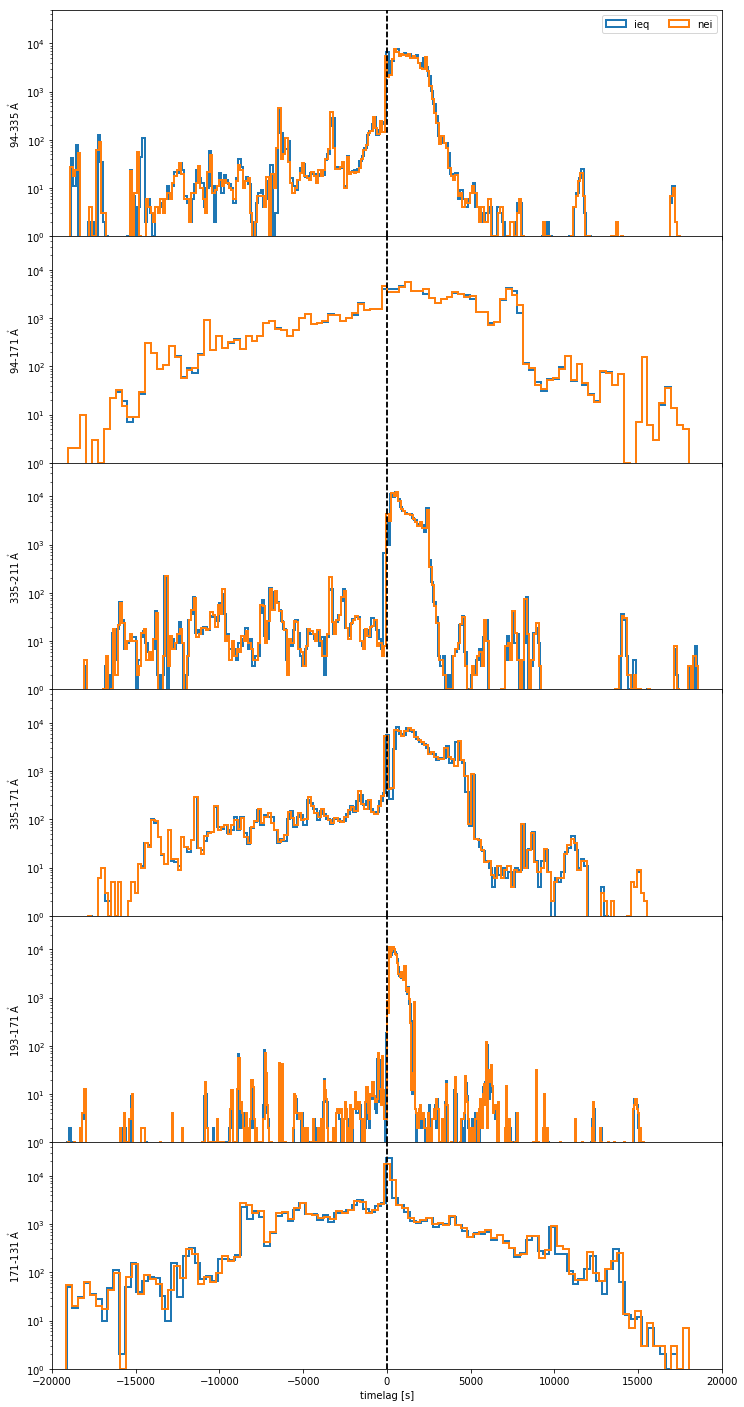

In [22]:
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False,}
fig,axes = plt.subplots(len(channel_pairs),1,figsize=(12,25),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    for j,ionization in enumerate(['ieq','nei']):
        tmp = timelag_maps['{}-{}'.format(*p)][ionization]
        data = tmp.data.flatten()
        tmp = correlation_maps['{}-{}'.format(*p)][ionization]
        data_cor = tmp.data.flatten()
        ax.hist(data[np.where(data_cor / data_cor.max() >= 0.2)], **params,label=ionization,color=f'C{j}',ls='-')
        ax.axvline(x=0,ls='--',color='k')
        if i==0:
            ax.legend(loc='best',ncol=2)
        ax.set_ylabel(r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
axes[0].set_xlim(-2e4,2e4)
axes[0].set_ylim(1,5e4)
axes[-1].set_xlabel(r'timelag [s]')

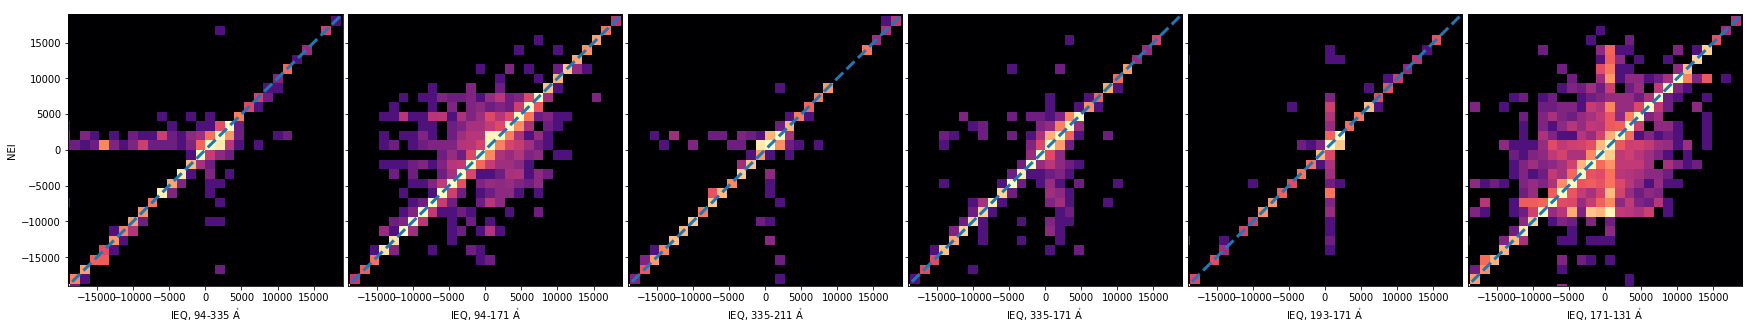

In [56]:
fig,axes = plt.subplots(1,len(channel_pairs),figsize=(30,5),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.02)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    tmp = timelag_maps['{}-{}'.format(*p)]['ieq']
    pts_ieq = tmp.data.flatten()
    #tmp = correlation_maps['{}-{}'.format(*p)]['ieq']
    #data_cor = tmp.data.flatten()
    #pts_ieq = data[np.where(data_cor / data_cor.max() >= 0.2)]
    tmp = timelag_maps['{}-{}'.format(*p)]['nei']
    pts_nei = tmp.data.flatten()
    #tmp = correlation_maps['{}-{}'.format(*p)]['nei']
    #data_cor = tmp.data.flatten()
    #pts_nei = data[np.where(data_cor / data_cor.max() >= 0.2)]
    #ax.plot(pts_ieq, pts_nei, marker='o', color='C0', ls='', alpha=0.1)
    ax.hist2d(pts_ieq, pts_nei, bins=30, range=[[-2e4, 2e4],[-2e4, 2e4]], norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e-1,vmax=1e3),cmap='magma')
    ax.plot([-2e4,2e4],[-2e4,2e4],ls='--',color='C0',lw=3)
    ax.set_xlabel(r'IEQ, {}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
axes[0].set_xlim(-1.9e4,1.9e4);
axes[0].set_ylim(-1.9e4,1.9e4);
axes[0].set_ylabel(r'NEI');